http://math.hws.edu/xJava/GA/

In [73]:
import numpy as np
import operator

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation
from IPython.display import display, clear_output,HTML

%matplotlib inline

# Create And fill map with food 

In [2]:
wm = 30
hm = 30

CUBE_EMPTY=0
CUBE_WALL=1
CUBE_FOOD=2
CUBE_EATER=3

def create_map() : 
    n_food = 100
    Map = np.zeros((wm,hm))
    #Setup walls
    Map[0,:]=CUBE_WALL
    Map[:,0]=CUBE_WALL
    Map[-1,:] =CUBE_WALL
    Map[:,-1] =CUBE_WALL
    # Put food 
    for i in range(1,n_food) : Map[np.random.randint(1,hm-1),np.random.randint(1,wm-1)]=2    
    return Map

# Create Eaters

In [3]:
n_state = 16 #0...15
n_poss_choice = 4 #0...3 0: forward 1: backward 2: turn right 3: turn left 
n_if = 4 # 0...3
len_chromosome = 64

In [4]:
class Eater : 
    state = 0
    score = 0
    history_moves = list()
    
    def __init__(self):
        self.position = np.random.randint(1,wm-1,(1,2))[0]
        self.direction = np.random.randint(0,4,1) # 0 : up 1: right 2: down 3 : left
        self.initialize_chromosome()
        
    def get_legacy(self,old_chromosome):
        self.chromosome = old_chromosome
    
    def initialize_chromosome(self) :
        ''' Initialize the chromosome with random actions and states
        '''
        self.chromosome = np.empty((len_chromosome,2),dtype=int)
        self.chromosome[:,0]=np.random.randint(0,n_poss_choice,(len_chromosome,)) # Actions
        self.chromosome[:,1]=np.random.randint(0,n_state,(len_chromosome,)) # States
    
    def do_one_step(self) : 
        [action,self.state] = self.get_decision()
        self.act(action)
    
    def get_decision(self) :
        '''
            Return new action and state from the chromosome given a state and what is the object in front.
            i_F ; In front
            state : previous state 
        '''
        if self.direction == 0 : view = [-1,0]
        if self.direction == 1 : view = [0,1]
        if self.direction == 2 : view = [1,0]
        if self.direction == 3 : view = [0,-1]
        view_pos = np.array(self.position)+np.array(view)
        i_F = Map[view_pos[0],view_pos[1]]
        #print('Action Index : {}'.format(int(i_F*n_state+self.state)))
        [action,state] = self.chromosome[int(i_F*n_state+self.state),:]
        return(action,state)
    
    def act(self,action) : 
        '''
        Realize the action 
        action: #0...3 0: forward 1: backward 2: turn right 3: turn left 
        '''
        motion = [0,0]
        if action == 0 : 
            if self.direction == 0 : motion = [-1,0]
            if self.direction == 1 : motion = [0,1]
            if self.direction == 2 : motion = [1,0]
            if self.direction == 3 : motion = [0,-1]
        if action == 1 : 
            if self.direction == 0 : motion = [1,0]
            if self.direction == 1 : motion = [0,-1]
            if self.direction == 2 : motion = [-1,0]
            if self.direction == 3 : motion = [0,1]
        if action == 2 : 
            self.direction +=1 
            if self.direction == 4 : self.direction =0
        if action == 3 :
            self.direction -=1 
            if self.direction == -1 : self.direction =3
        self.position = self.move(motion)
        self.eat()
        
        
    def move(self,motion):
        n_position = np.array(self.position)+np.array(motion)
        if Map[n_position[0],n_position[1]] != CUBE_WALL and Map[n_position[0],n_position[1]] != CUBE_EATER :
            self.history_moves.append(tuple(n_position))
            return n_position
        else : return self.position
    
    def eat(self) : 
        if Map[self.position[0],self.position[1]] == CUBE_FOOD : 
            self.score +=1
            Map[self.position[0],self.position[1]] = CUBE_EMPTY
            while True:
                x = np.random.randint(1,hm-1)
                y = np.random.randint(1,wm-1)
                if(Map[x,y] == CUBE_EMPTY) :
                    break
            Map[x,y]=CUBE_FOOD

    def mate(self,eater2) : 
        '''
            Mate with another eater : their chromosomes crossover
        '''
        temp = self.chromosome.copy()
        idx = np.random.randint(0,64)
        temp[idx:,:] = eater2.chromosome[idx:,:]
        return temp

In [5]:
def mating(eaters) : 
    children = list()
    t =sorted(eaters,key=operator.attrgetter('score'),reverse=True)
    selection = t[0:int(round(n_eaters*p_selection))]
    while len(children) < max_children :
        i = np.random.randint(0,len(selection))
        j = np.random.randint(0,len(selection))
        if i!=j : 
            c = selection[i].mate(selection[j])
            child = Eater()
            child.get_legacy(c)
            children.append(child)
    return children

def mutate(eaters,n_mutation) : 
    for i in range(0,n_mutation) : 
        eaters[np.random.randint(0,n_eaters)].chromosome[np.random.randint(0,len_chromosome),:] = [np.random.randint(0,n_if),np.random.randint(0,n_state)]

### Graphic functions

In [6]:
# Custom colors for Map :
map_colors = {CUBE_WALL:'black',CUBE_FOOD:'green',CUBE_EATER:'purple'}
cvr = colors.ColorConverter()
tmp = sorted(map_colors.keys())
cols_rgb = [cvr.to_rgb(map_colors[k]) for k in tmp]
intervals = np.array(tmp + [tmp[-1]+1]) - 0.5
cmap, norm = colors.from_levels_and_colors(intervals,cols_rgb)

In [82]:
# Draw Map :
def draw_map(Map) :
    # Clear previous plot
    #plt.clf()
    # Plots the next
    return plt.imshow(Map,cmap = cmap, norm = norm,animated=True)

# Draw Map with Eaters
def populated_map(Map, eaters) :
    # Reset map with the food left (remove old eaters), However it appears as if you keep them in the eaters...
    Map_populated = Map.copy()
    # Add new eaters
    for i in range(0,len(eaters)) :
        Map_populated[eaters[i].position[0],eaters[i].position[1]] = CUBE_EATER
    
    return Map_populated

## Algorithm execution

In [83]:
n_eaters = 10
p_selection=0.33
max_children = 100
n_mutation=5
N_GENERATION = 3
N_MOVES = 100
Map=create_map()
eaters = [Eater() for e in range(0,n_eaters) ]
# Draw starting map :
print('Starting world :')
#draw_map(Map)

Starting world :


Evolutions :
> Gen 0 Mean Score : 0  Max :2
> Gen 1 Mean Score : 1  Max :7
> Gen 2 Mean Score : 2  Max :9


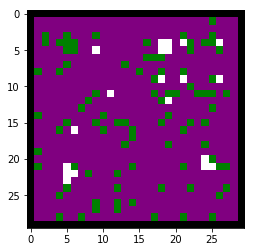

In [84]:
total_eat = 0
ims = []
fig = plt.figure()
print('Evolutions :')
for i in range(0,N_GENERATION) :
    for j in range(1,N_MOVES) : 
        [a.do_one_step() for a in eaters]
        ims.append([draw_map(populated_map(Map,eaters))])
        #ims.append([im])
    if i%1 == 0:
        print('> Gen {} Mean Score : {}  Max :{}'.format(i,int(np.mean([a.score for a in eaters])),int(np.max([a.score for a in eaters]))))
    total_eat = total_eat+np.sum([a.score for a in eaters])
    eaters = mating(eaters)
    mutate(eaters,n_mutation)

In [85]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=1000)

In [86]:
HTML(ani.to_html5_video())